<a href="https://colab.research.google.com/github/pdeleonsoria/4GeeksAcademyPerfilPublico/blob/master/Notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files


A partir de la experiencia en libreta Notebook1. He decidido que los datos son demasiado dispares para hacer un único modelo. Por lo que, he decidido dar un nuevo enfoque. El cáncer de próstata es uno de los cánceres con mayor supervivencia. Por lo general, la superviviencia a un cáncer se mide respecto a los 5 y a los 10 años post diagnóstico. Por lo que he decidido que mi proyecto se divida en dos partes:

1- Una parte inicial de clasificación, en la cual se decida si un cáncer es agresivo (menos de 5 años de supervivencia) o no (más de 5 años de supervivencia)
2- Una calculadora de cuanto tiempo post diagnóstico tiene el paciente de vida, (como novedad, en días.)

Pese a que medicamente, el proyecto no parezca tener interés, puesto que los protocolos a seguir y la ética médica ordena tratar a todos los pacientes de igual manera, sea su tiempo estimado de superviviencia el que sea. Para otras entidades como aseguradoras o bancos, puede ser interesante conocer el tiempo de vida de un cliente.

Por otra parte, para el cliente también puede ser interesante. Ya que, por ejemplo, un hombre con cáncer de prostata no agresivo, con una supervivencia de más de 10 años post diagnóstico, puede aprovecharse de esta información para hacerse un seguro de vida y pagar una cuota similar a la de un hombre sano que tuviese alrededor de 70 años.


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/proyecto cancer/cancer_data_eng.csv", encoding='latin-1')
df.head()
df.columns


<ipython-input-14-43e302081fce>:1: DtypeWarning: Columns (3,5,6,7,8,9,10,13,14,23,24,25,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/drive/MyDrive/proyecto cancer/cancer_data_eng.csv", encoding='latin-1')


Index(['Patient.Code', 'RCBP.Name', 'Gender', 'Date.of.Birth', 'Age',
       'Raca.Color', 'Nationality', 'Naturality.State', 'Naturality',
       'Degree.of.Education', 'State.Civil', 'Code.Profession',
       'Name.Occupation', 'Status.Address', 'City.Address',
       'Description.of.Topography', 'Topography.Code',
       'Morphology.Description', 'Code.of.Morphology',
       'Description.of.Disease', 'Illness.Code', 'Child.Illness.Description',
       'Child.Illness.Code', 'Youth.Adult.Illness.Description',
       'Code.of.Disease.Adult.Young.', 'Indicator.of.Rare.Case',
       'Diagnostic.means', 'Extension', 'Laterality', 'Statement', 'TNM',
       'Status.Vital', 'Type.of.Death', 'Date.of.Death',
       'Date.of.Last.Contact', 'Date.of.Diagnostic', 'Distant.metastasis',
       'year'],
      dtype='object')

Renombrar las columnas porque aunque en este caso no entre en conflicto con la base de datos, como estoy reutilizando código del anterior notebook, necesito que las columnas se llamen igual


In [ ]:
df = df.rename(columns={'Patient.Code': 'Patient_Code',
                         'RCBP.Name': 'RCBP_Name',
                         'Date.of.Birth': 'Date_of_Birth',
                         'Raca.Color': 'Raca_Color',
                         'Naturality.State': 'Naturality_State',
                         'Degree.of.Education': 'Degree_of_Education',
                        'State.Civil' : 'State_Civil',
                         'Code.Profession': 'Code_Profession',
                         'Name.Occupation': 'Name_Occupation',
                         'Status.Address': 'Status_Address',
                         'City.Address': 'City_Address',
                         'Description.of.Topography': 'Description_of_Topography',
                         'Topography.Code': 'Topography_Code',
                         'Morphology.Description': 'Morphology_Description',
                         'Code.of.Morphology': 'Code_of_Morphology',
                         'Description.of.Disease': 'Description_of_Disease',
                         'Illness.Code': 'Illness_Code',
                         'Child.Illness.Description': 'Child_Illness_Description',
                         'Child.Illness.Code': 'Child_Illness_Code',
                         'Code.of.Disease.Adult.Young.': 'Code_of_Disease_Adult_Young',
                         'Youth.Adult.Illness.Description': 'Youth_Adult_Illness_Description',
                         'Indicator.of.Rare.Case': 'Indicator_of_Rare_Case',
                         'Diagnostic.means': 'Diagnostic_means',
                         'Status.Vital': 'Status_Vital',
                         'Type.of.Death': 'Type_of_Death',
                         'Date.of.Death': 'Date_of_Death',
                         'Date.of.Last.Contact': 'Date_of_Last_Contact',
                         'Date.of.Diagnostic': 'Date_of_Diagnostic',
                         'Distant.metastasis': 'Distant_metastasis'})

Eliminar columnas que no sean útiles por el tipo de cáncer
Eliminar filas duplicadas y columnas completamente vacías

In [ ]:
subdf_pros = df[df['Description_of_Disease'] == 'PROSTATA']
df_mod= subdf_pros.drop(columns=["Patient_Code", "RCBP_Name", "Gender", "Date_of_Birth", "Naturality", "Code_Profession", "Topography_Code", "Code_of_Morphology",
                         "Illness_Code", "Child_Illness_Code", "Child_Illness_Description","Code_of_Disease_Adult_Young", "Youth_Adult_Illness_Description", "Laterality", "City_Address", "Description_of_Topography", "Description_of_Disease", "Indicator_of_Rare_Case","Date_of_Last_Contact"])

df_mod.duplicated().sum()
df_mod.drop_duplicates(inplace=True)
df_mod.shape

df_mod = df_mod.dropna(how='all')



En la columna tipo de muerte, escribir NO si el paciente esta Vivo
En la columna status vital, escribir morto si en tipo de muerte aparece cancer
En la columna fecha de muerte, escribir 0 si en status vital aparece vivo

In [ ]:
df_mod["Type_of_Death"], df_mod["Status_Vital"] = zip(*df_mod.apply(
    lambda row: (
        "NO" if pd.isna(row["Type_of_Death"]) and row["Status_Vital"] == "VIVO" else row["Type_of_Death"],
        "MORTO" if row["Type_of_Death"] in ["CÂNCER", "NÃO CÂNCER"] else row["Status_Vital"]
    ),
    axis=1
))

df_mod.loc[pd.isna(df_mod["Date_of_Death"]) & (df_mod["Status_Vital"] == "VIVO"), "Date_of_Death"] = 0

En TNM eliminar todo lo que no sean numeros (incluidos espacios)
Sustituit in situ por localizado ya que son complemanete intercambiables (se podría haber hecho al revés con el mismo resultado)
Cambiar el formato de fecha de muerte a datetime para poder sacar más adelante el tiempo de superviviencia

In [ ]:
df_mod["TNM"] = df_mod["TNM"].str.replace(r"[^\d]", "", regex=True)
df_mod["Extension"] = df_mod["Extension"].replace("In situ", "Localizado")
df_mod['Date_of_Death'] = df_mod['Date_of_Death'].replace({'0': pd.NaT, '0000-00-00': pd.NaT})

Pasar de pandas array a datetime
Crear tiempo post diagnostico con la diferencia de dias entre fecha de muerte y fecha de diagnostico

In [ ]:
df_mod['Date_of_Death'] = pd.to_datetime(df_mod['Date_of_Death'], errors='coerce')
df_mod['Date_of_Diagnostic'] = pd.to_datetime(df_mod['Date_of_Diagnostic'], errors='coerce')

df_mod['Tiempo_Post_Diagnostico'] = (df_mod['Date_of_Death'] - df_mod['Date_of_Diagnostic']).dt.days
df_mod.loc[df_mod['Status_Vital'] != "MORTO", 'Tiempo_Post_Diagnostico'] = None

In [ ]:
df_morto = df_mod[df_mod['Status_Vital'] == 'MORTO']

Sintetizar y agrupar los tipos de canceres en canceres representativos. Para hacer esta operación me he basado en la peligrosidad, la rareza y la zona de los canceres por eso, pese a que algunos no se llamen igual, a nivel representativo son válido

In [ ]:
cancer_classification = {

    'ADENOCARCINOMA, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS CLARAS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA MUCINOSO': 'ADENOCARCINOMA',
    "ADENOCARCINOMA TUBULAR": 'ADENOCARCINOMA',
    "ADENOCARCINOMA VILOSO": 'ADENOCARCINOMA',
    "ADENOCARCINOMA ESQUIRROSO": 'ADENOCARCINOMA',
    "ADENOCARCINOMA EM POLIPO ADENOMATOSO": 'ADENOCARCINOMA',
    "ADENOCARCINOMA EM ADENOMA TUBULOVILOSO": 'ADENOCARCINOMA',
    "ADENOCARCINOMA COM DIFERENCIACAO NEUROENDOCRINA": 'ADENOCARCINOMA',
    "ADENOCARCINOMA COM DIFERENCIACAO NEUROENDOCRINA, SOE": 'ADENOCARCINOMA',
    'ADENOCARCINOMA TRABECULAR': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS ESCAMOSAS': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS TRANSICIONAIS': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS PEQUENAS': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS MEDIAS': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS GRANDES': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS CLARAS': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS ESCAMOSAS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS TRANSICIONAIS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS PEQUENAS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS MEDIAS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS GRANDES, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS CLARAS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE CELULAS ESCAMOSAS, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA PRODUTOR DE MUCINA': 'ADENOCARCINOMA',
    'ADENOCARCINOMA PRODUTOR DE MUCINA, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA C/ METAPLASIA CARTILAGINOSA E OSSEA, SOE': 'ADENOCARCINOMA',
    "ADENOCARCINOMA C/ METAPLASIA CARTILAGINOSA E OSSEA": 'ADENOCARCINOMA',


    'CARCINOMA DE CELULAS ACINOSAS': 'CARCINOMA',
    'CARCINOMA, SOE': 'CARCINOMA',
    "CARCINOMA ESCAMOCELULAR, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS ESCAMOSAS, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS TRANSICIONAIS, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS PEQUENAS, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS MEDIAS, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS GRANDES, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS CLARAS, SOE": 'CARCINOMA',
    "CARCINOMA DE CELULAS ESCAMOSAS": 'CARCINOMA',
    "CARCINOMA DE CELULAS TRANSICIONAIS": 'CARCINOMA',
    "CARCINOMA DE CELULAS PEQUENAS": 'CARCINOMA',
    "CARCINOMA DE CELULAS MEDIAS": 'CARCINOMA',
    "CARCINOMA DE CELULAS GRANDES": 'CARCINOMA',
    "CARCINOMA DE CELULAS CLARAS": 'CARCINOMA',
    "CARCINOMA PAPILAR, SOE": 'CARCINOMA',
    'CARCINOMA ESCAMOSO MICRO-INVASOR': "CARCINOMA",
    'CARCINOMA ANAPLASICO, SOE': 'CARCINOMA',
    'CARCINOMA IN SITU, SOE': 'CARCINOMA',
    'CARCINOMA SOLIDO, SOE': 'CARCINOMA',



    'SARCOMA, SOE': 'SARCOMA,',
    'LEIOMIOSSARCOMA, SOE': 'LEIOMIOSSARCOMA',
    'RABDOMIOSSARCOMA, SOE': 'RABDOMIOSSARCOMA',

    'MELANOMA MALIGNO, SOE': 'CÁNCER DE PIEL',
    'EPITELIOMA MALIGNO': 'CÁNCER DE PIEL',
    'MELANOMA, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS CLARAS, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS ESCAMOSAS, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS TRANSICIONAIS, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS PEQUENAS, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS MEDIAS, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS GRANDES, SOE': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS CLARAS': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS ESCAMOSAS': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS TRANSICIONAIS': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS PEQUENAS': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS MEDIAS': 'CÁNCER DE PIEL',
    'MELANOMA DE CELULAS GRANDES': 'CÁNCER DE PIEL',


    'CARCINOMA NEUROENDOCRINO, SOE': 'CARCINOMA NEUROENDOCRINO',
    'TUMOR CARCINOIDE, SOE': 'CARCINOMA NEUROENDOCRINO',


    'NEOPLASIA MALIGNA': 'NEOPLASIA',
    'NEOPLASMA MALIGNO': 'NEOPLASIA',
    'NEOPLASIA MALIGNA SEM CONFIRMACAO MICROSCOPICA': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS CLARAS': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS ESCAMOSAS': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS TRANSICIONAIS': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS PEQUENAS': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS MEDIAS': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS GRANDES': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS CLARAS, SOE': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS ESCAMOSAS, SOE': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS TRANSICIONAIS, SOE': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS PEQUENAS, SOE': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS MEDIAS, SOE': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS GRANDES, SOE': 'NEOPLASIA',
    'NEOPLASIA DE CELULAS CLARAS, SOE': 'NEOPLASIA',
    'NEOPLASIA GLANDULAR INTRAEPITELIAL, GRAU III': 'NEOPLASIA',


    'CARCINOMA VERRUCOSO, SOE': 'CARCINOMA VERRUCOSO',
    'CARCINOSSARCOMA, SOE': 'CARCINOSARCOMA',

    "FIBROSSARCOMA, SOE": 'FIBROSARCOMA',
    "FIBRINOMA, SOE": 'FIBRINOMA',
    "CARCINOMA INDIFERENCIADO, SOE": 'CARCINOMA INDIFERENCIADO',
    "TUMOR MALIGNO DE CELULAS GIGANTES": 'TUMOR MALIGNO DE CELULAS GIGANTES',
    'ADENOCARCINOMA IN SITU, SOE': 'ADENOCARCINOMA',
    'ADENOCARCINOMA DE PROPAGACAO SUPERFICIAL': 'ADENOCARCINOMA',
    'ADENOCARCINOMA PAPILAR, SOE': 'ADENOCARCINOMA',
    "CARCINOMA DE CELULAS EM ANEL DE SINETE": "CARINOMA DE CELULAS EN ANILLO",
    'SARCOMA FUSOCELULAR': "SARCOMA",




    "SEMINOMA, SOE": 'SEMINOMA',
}

df_morto['Morphology_Description'] = df_morto['Morphology_Description'].replace(cancer_classification)

Factorización de las categoricas y creacion de una columna nueva (esto es heredado del codigo anterior, actualmente hubiera hecho un mapeo de factorización (cmo hice en el notebook 103)

In [ ]:
df_morto_encoded = pd.get_dummies(df_morto, columns=['Raca_Color'])
df_morto["Raca_Color_n"] = pd.factorize(df_morto["Raca_Color"])[0]
df_morto["State_Civil_n"]= pd.factorize(df_morto["State_Civil"])[0]
df_morto["Name_Occupation_n"]= pd.factorize(df_morto["Name_Occupation"])[0]
df_morto["Morphology_Description_n"]= pd.factorize(df_morto["Morphology_Description"])[0]
df_morto["Extension_n"]= pd.factorize(df_morto["Extension"])[0]

Fill de Na con la media de la edad

In [ ]:
mean_age = df_morto['Age'].mean()
df_morto['Age'] = df_morto['Age'].fillna(mean_age).astype(int)
df_morto['Age'] = df_morto['Age'].astype(int)
df_morto['Age_Group'] = pd.cut(df_morto['Age'], bins=range(0, df_morto['Age'].max() + 5, 5), right=False)

Eliminación de columnas que no considero que aporten valor al diagnóstico

In [ ]:

df_morto_pred= df_morto.drop(columns=["Name_Occupation", "Naturality_State", "Degree_of_Education", "Date_of_Diagnostic", "year", "Age_Group", "Raca_Color_n", "State_Civil_n", "Name_Occupation_n", "Morphology_Description_n", "Extension_n", "Date_of_Death", "Status_Vital", "Type_of_Death", "Statement", "Status_Address", "Distant_metastasis"])

Creación del df final de trabajo, que no contenga valores nulos, o menores de 90

In [ ]:
df_morto_2 = df_morto_pred[df_morto_pred["Tiempo_Post_Diagnostico"] != 0]
df_morto_2 = df_morto_2.dropna(subset=["Tiempo_Post_Diagnostico"])
df_morto_2 = df_morto_2[df_morto_2["Tiempo_Post_Diagnostico"] >= 90]

Cambiar las columnas vacias de TNM por nan (para posterior tratamiento)
Cambiar los valores de menos de 3 cifras de TNM por 3 cifras. Ya que TNM alude a 3 conceptos: Tamaño de tumor, nodulos cercanos afectados (ganglios) y metastasis

In [ ]:
df_morto_2["TNM"] = df_morto_2["TNM"].replace("", np.nan)

replacement_TNM = {
    "0": "000",
    "00": "000",
    "1": "100",
    "01": "010",
    "11": "110",
    "2": "200",
    "20": "200",
    "21": "210",
    "3": "300",
    "30": "300",
    "31": "310",
    "41": "410",
    "99": "990"
}

df_morto_2['TNM'] = df_morto_2['TNM'].replace(replacement_TNM)


Visualuzación de columnas con Nan

In [ ]:
categorical_cols_with_na = ["Raca_Color", "Nationality", "State_Civil", "Diagnostic_means", "Extension", "TNM"]
df_categorical = df_morto_2[categorical_cols_with_na].copy()

# Verificar que se ha creado correctamente
print(df_categorical.isnull().sum())

Raca_Color           2002
Nationality          2666
State_Civil          4005
Diagnostic_means      163
Extension           10057
TNM                 15389
dtype: int64


Tratamiento de los Nan:
En este caso he decidido hacer el fill de las columnas utilizando KNN. La razón por la cual no puedo urilizar otros métodos como la media (en el caso de la edad) es que los valores que hay que rellenar como TNM, Extension; Diagnostic_means atienden a criterios de clasificación y no de cantidad por lo que se debe rellenar con clasificación y no con regresión

In [ ]:

# Paso 1: Convertir categorías a números
mappings = {}
for col in df_categorical.columns:
    uniques = df_categorical[col].dropna().unique().tolist()
    mapping = {category: idx for idx, category in enumerate(uniques)}
    reverse_mapping = {idx: category for category, idx in mapping.items()}
    mappings[col] = (mapping, reverse_mapping)

    # Mapear las categorías a índices numéricos, dejando los NaN como están
    df_categorical[col] = df_categorical[col].map(mapping)

# Paso 2: Usar KNN para imputar los valores faltantes
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_array = knn_imputer.fit_transform(df_categorical)

# Convertir el resultado imputado a DataFrame
df_categorical_imputed = pd.DataFrame(imputed_array, columns=df_categorical.columns)

# Paso 3: Reconstruir las categorías originales
for col in df_categorical_imputed.columns:
    _, reverse_mapping = mappings[col]
    df_categorical_imputed[col] = df_categorical_imputed[col].round().astype(int).map(reverse_mapping)

# Verificar si los valores faltantes han sido eliminados
print(df_categorical_imputed.isnull().sum())


Raca_Color          0
Nationality         0
State_Civil         0
Diagnostic_means    0
Extension           0
TNM                 0
dtype: int64


Para KNN había que factorizar los valores categóricos y para continuar deshago la factorización

In [ ]:
#73 Paso 1: Asegurarse de que los índices de df_categorical_imputed coincidan con df_morto_2
df_categorical_imputed.index = df_categorical.index  # Igualar los índices al original

# Paso 2: Eliminar las columnas originales de df_morto_2
df_morto_2 = df_morto_2.drop(columns=categorical_cols_with_na)

# Paso 3: Fusionar los DataFrames
df_morto_2 = pd.concat([df_morto_2, df_categorical_imputed], axis=1)

# Paso 4: Verificar las dimensiones finales
print(f"Dimensiones finales del DataFrame: {df_morto_2.shape}")  # Debería ser (18498, <número total de columnas>)

Dimensiones finales del DataFrame: (16507, 9)


In [ ]:
df_morto_2

,Age,Morphology_Description,Tiempo_Post_Diagnostico,Raca_Color,Nationality,State_Civil,Diagnostic_means,Extension,TNM
319,85,ADENOCARCINOMA,1337.0,PARDA,BRASIL,VIÚVO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,401
328,70,CARCINOMA,1351.0,PARDA,BRASIL,VIÚVO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,401
333,75,ADENOCARCINOMA,785.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200
385,82,ADENOCARCINOMA,1193.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200
425,68,ADENOCARCINOMA,280.0,PARDA,BRASIL,VIÚVO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,401
...,...,...,...,...,...,...,...,...,...
1759948,76,ADENOCARCINOMA,588.0,PARDA,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,300
1760023,55,ADENOCARCINOMA,2257.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200
1760027,70,ADENOCARCINOMA,2015.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200
1760031,73,ADENOCARCINOMA,1478.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200


In [ ]:
#Objetivo 1: Predecir que tipo de cáncer es:
#1.

# Crear la nueva columna "Agresivo" con la condición especificada
df_morto_2['Agresivo'] = df_morto_2['Tiempo_Post_Diagnostico'].apply(lambda x: 1 if 90 <= x <= 1825 else 0)
df_morto_2['No_Agresivo'] = df_morto_2['Tiempo_Post_Diagnostico'].apply(lambda x: 1 if x >= 1825 else 0)
df_morto_2 = df_morto_2.loc[df_morto_2['Tiempo_Post_Diagnostico'] <= 3650]

# Mostrar las primeras filas para verificar
df_morto_2

,Age,Morphology_Description,Tiempo_Post_Diagnostico,Raca_Color,Nationality,State_Civil,Diagnostic_means,Extension,TNM,Agresivo,No_Agresivo
319,85,ADENOCARCINOMA,1337.0,PARDA,BRASIL,VIÚVO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,401,1,0
328,70,CARCINOMA,1351.0,PARDA,BRASIL,VIÚVO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,401,1,0
333,75,ADENOCARCINOMA,785.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200,1,0
385,82,ADENOCARCINOMA,1193.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200,1,0
425,68,ADENOCARCINOMA,280.0,PARDA,BRASIL,VIÚVO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,401,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1759938,70,ADENOCARCINOMA,151.0,PARDA,BRASIL,SOLTEIRO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,311,1,0
1759948,76,ADENOCARCINOMA,588.0,PARDA,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,300,1,0
1760023,55,ADENOCARCINOMA,2257.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200,0,1
1760027,70,ADENOCARCINOMA,2015.0,BRANCO,BRASIL,CASADO,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,200,0,1


In [ ]:
# Factorizar todas las columnas del dataframe
for column in df_morto_2.columns:
    if df_morto_2[column].dtype == 'object':  # Solo factorizar columnas categóricas
        df_morto_2[column], _ = pd.factorize(df_morto_2[column])

# Mostrar las primeras filas del dataframe factorizado
print(df_morto_2.head())

     Age  Morphology_Description  Tiempo_Post_Diagnostico  Raca_Color  \
319   85                       0                   1337.0           0   
328   70                       1                   1351.0           0   
333   75                       0                    785.0           1   
385   82                       0                   1193.0           1   
425   68                       0                    280.0           0   

     Nationality  State_Civil  Diagnostic_means  Extension  TNM  Agresivo  \
319            0            0                 0          0    0         1   
328            0            0                 0          0    0         1   
333            0            1                 0          1    1         1   
385            0            1                 0          1    1         1   
425            0            0                 0          0    0         1   

     No_Agresivo  
319            0  
328            0  
333            0  
385            0  
425

<ipython-input-28-27521c5ec1cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_morto_2[column], _ = pd.factorize(df_morto_2[column])
<ipython-input-28-27521c5ec1cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_morto_2[column], _ = pd.factorize(df_morto_2[column])
<ipython-input-28-27521c5ec1cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

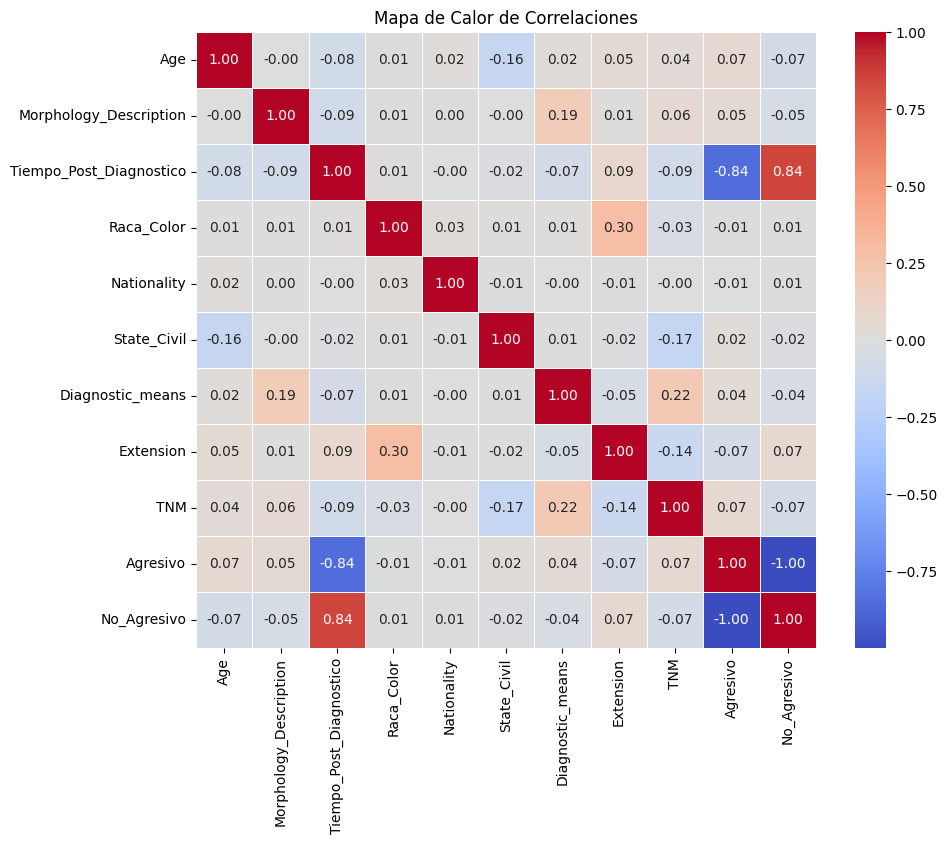

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df_morto_2.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor de Correlaciones")
plt.show()

In [ ]:
# Excluir 'Tiempo_Post_Diagnostico' y calcular las correlaciones con 'Agresivo' y 'No_Agresivo'
correlation_with_agresivo = df_morto_2.drop(columns=['Tiempo_Post_Diagnostico']).corr()['Agresivo']
correlation_with_no_agresivo = df_morto_2.drop(columns=['Tiempo_Post_Diagnostico']).corr()['No_Agresivo']

# Ordenar de mayor a menor correlación
correlation_with_agresivo = correlation_with_agresivo.sort_values(ascending=False)
correlation_with_no_agresivo = correlation_with_no_agresivo.sort_values(ascending=False)

# Mostrar los resultados
print("Correlaciones con 'Agresivo':\n", correlation_with_agresivo)
print("\nCorrelaciones con 'No_Agresivo':\n", correlation_with_no_agresivo)

Correlaciones con 'Agresivo':
 Agresivo                  1.000000
Age                       0.070626
TNM                       0.070567
Morphology_Description    0.051757
Diagnostic_means          0.041010
State_Civil               0.020305
Nationality              -0.005652
Raca_Color               -0.008616
Extension                -0.065836
No_Agresivo              -0.999126
Name: Agresivo, dtype: float64

Correlaciones con 'No_Agresivo':
 No_Agresivo               1.000000
Extension                 0.065504
Raca_Color                0.008116
Nationality               0.005601
State_Civil              -0.020124
Diagnostic_means         -0.041113
Morphology_Description   -0.051890
Age                      -0.070063
TNM                      -0.070989
Agresivo                 -0.999126
Name: No_Agresivo, dtype: float64


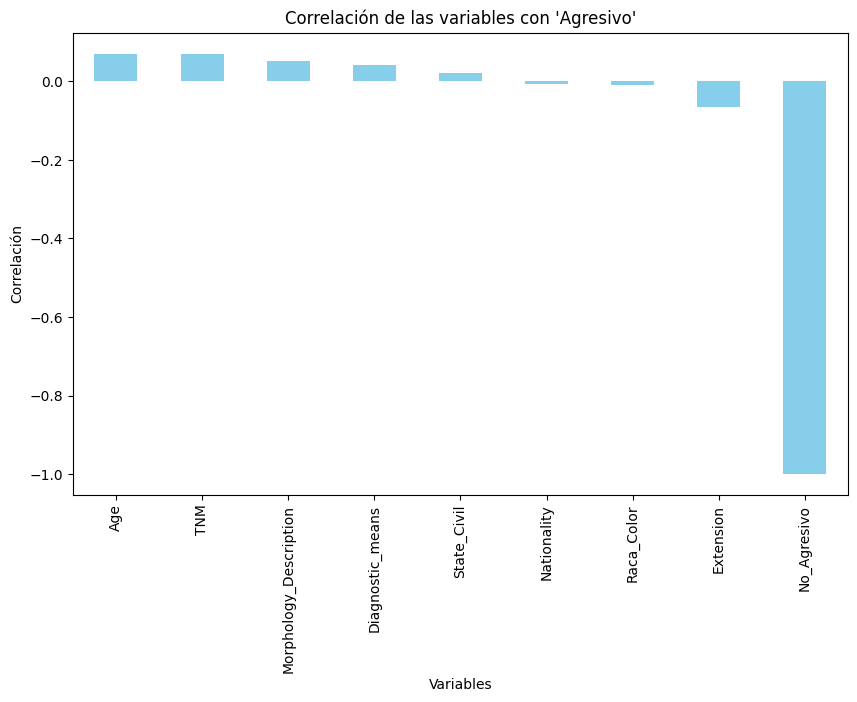

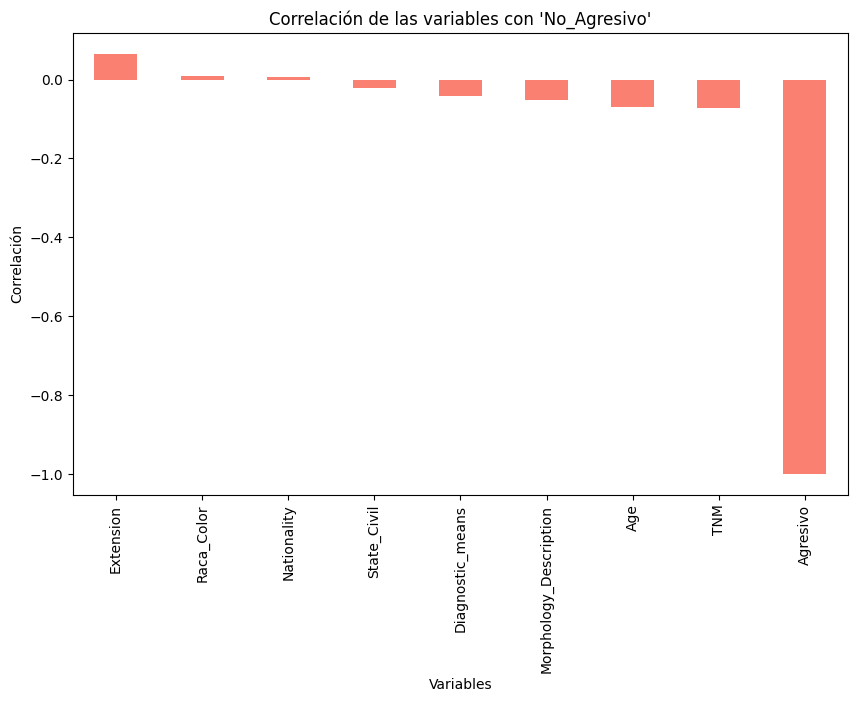

In [ ]:
# Graficar las correlaciones con 'Agresivo'
plt.figure(figsize=(10, 6))
correlation_with_agresivo.drop('Agresivo').plot(kind='bar', color='skyblue')
plt.title("Correlación de las variables con 'Agresivo'")
plt.ylabel("Correlación")
plt.xlabel("Variables")
plt.show()

# Graficar las correlaciones con 'No_Agresivo'
plt.figure(figsize=(10, 6))
correlation_with_no_agresivo.drop('No_Agresivo').plot(kind='bar', color='salmon')
plt.title("Correlación de las variables con 'No_Agresivo'")
plt.ylabel("Correlación")
plt.xlabel("Variables")
plt.show()

RF con todas las características

                 Variable  Importancia
0                     Age     0.613074
7                     TNM     0.153379
4             State_Civil     0.072792
2              Raca_Color     0.060344
1  Morphology_Description     0.036156
6               Extension     0.028488
5        Diagnostic_means     0.021949
3             Nationality     0.013817


<ipython-input-163-d0e43e5ef8fc>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importance_df, palette='viridis')


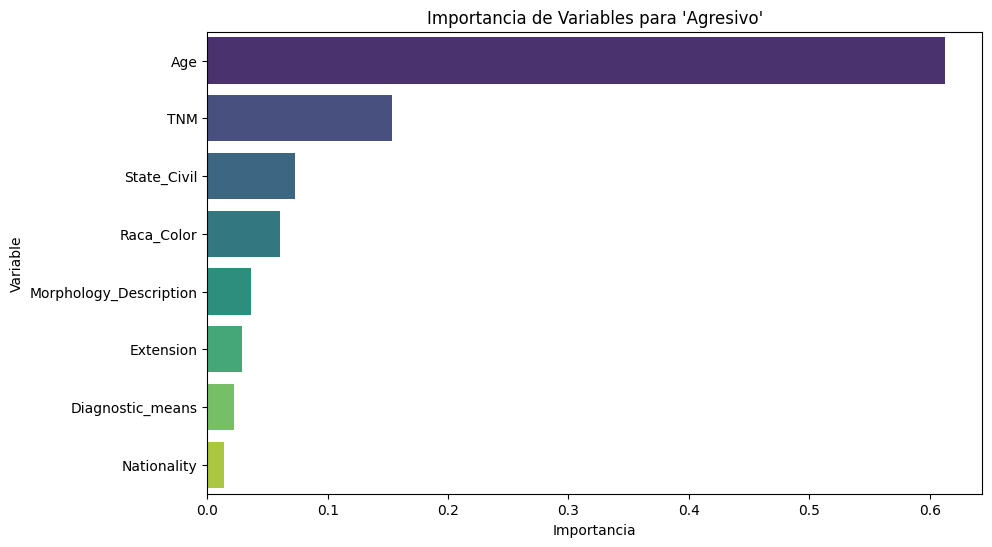

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Definir X (predictoras) y y (variable objetivo)
X = df_morto_2.drop(columns=['Agresivo', 'No_Agresivo', 'Tiempo_Post_Diagnostico'])
y = df_morto_2['Agresivo']

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Importancia de las variables
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importances})
importance_df = importance_df.sort_values(by='Importancia', ascending=False)

# Mostrar las importancias
print(importance_df)

# Graficar las importancias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importance_df, palette='viridis')
plt.title("Importancia de Variables para 'Agresivo'")
plt.show()

In [ ]:
X = df_morto_2.drop(columns=['Agresivo', 'No_Agresivo', 'Tiempo_Post_Diagnostico'])
y = df_morto_2['Agresivo']  # Cambia a 'No_Agresivo' si prefieres

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train

,Age,Morphology_Description,Raca_Color,Nationality,State_Civil,Diagnostic_means,Extension,TNM
784850,64,0,1,0,0,0,1,1
1528582,77,0,0,0,1,0,1,9
695534,69,2,0,0,1,0,0,6
1472938,76,0,1,0,1,0,1,1
383051,67,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
607804,87,2,0,0,0,0,1,4
1546746,65,0,0,0,2,0,0,9
614103,73,0,1,0,3,0,1,2
396788,77,0,0,0,1,0,1,1


In [ ]:
X_test

,Age,Morphology_Description,Raca_Color,Nationality,State_Civil,Diagnostic_means,Extension,TNM
661969,74,0,0,0,1,0,0,3
1227031,73,0,0,0,0,0,0,0
847320,81,0,0,0,1,0,1,1
1249580,74,0,2,0,1,0,0,3
1498989,65,0,0,0,3,0,1,9
...,...,...,...,...,...,...,...,...
1576599,81,0,0,0,0,0,1,12
416559,77,0,1,0,0,0,1,9
780076,63,0,0,0,1,0,0,2
452555,59,0,0,0,1,0,0,3


In [ ]:
# Obtener el valor mínimo
min_age = X_train["Age"].min()

# Obtener el valor máximo
max_age = X_train["Age"].max()

# Mostrar los valores
print("Valor mínimo de Age:", min_age)
print("Valor máximo de Age:", max_age)


Valor mínimo de Age: 8
Valor máximo de Age: 102


In [ ]:
# Obtener el valor mínimo
min_age = X_test["Age"].min()

# Obtener el valor máximo
max_age = X_test["Age"].max()

# Mostrar los valores
print("Valor mínimo de Age:", min_age)
print("Valor máximo de Age:", max_age)

Valor mínimo de Age: 3
Valor máximo de Age: 103


In [ ]:
columns_to_scale = ['Age']

# Crear el escalador
scaler1 = MinMaxScaler()

# Ajustar el escalador solo con los datos de entrenamiento
scaler1.fit(X_train[columns_to_scale])

# Transformar tanto train como test
X_train[columns_to_scale] = scaler1.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler1.transform(X_test[columns_to_scale])

# Confirmar que solo se escaló la columna 'Age'
print(X_test.head())

NameError: name 'X_train' is not defined

In [ ]:
# Obtener el valor mínimo
min_age = X_test["Age"].min()

# Obtener el valor máximo
max_age = X_test["Age"].max()

# Mostrar los valores
print("Valor mínimo de Age:", min_age)
print("Valor máximo de Age:", max_age)

Valor mínimo de Age: -0.05319148936170213
Valor máximo de Age: 1.0106382978723405


In [ ]:
# Obtener el valor mínimo
min_age = X_train["Age"].min()

# Obtener el valor máximo
max_age = X_train["Age"].max()

# Mostrar los valores
print("Valor mínimo de Age:", min_age)
print("Valor máximo de Age:", max_age)

Valor mínimo de Age: 0.0
Valor máximo de Age: 0.9999999999999999


In [ ]:

rf_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = rf_model.predict(X_test)

In [ ]:
# Mostrar resultados
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7125183135275924

In [ ]:
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.4817902837439636

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

KeyboardInterrupt: 

Mejores hiperparámetros encontrados:
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}


In [ ]:
best_model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=20, class_weight='balanced', random_state=42)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

In [ ]:
accuracy_best_rf = accuracy_score(y_test, y_pred_best)
f1_best_rf = f1_score(y_test, y_pred_best, average='macro')

print("Random Forest:")
print(f"Accuracy: {accuracy_best_rf}")
print(f"F1-score: {f1_best_rf}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_best))

Random Forest:
Accuracy: 0.5775679635357317
F1-score: 0.5378920015796409

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.31      0.57      0.40      1537
           1       0.80      0.58      0.67      4606

    accuracy                           0.58      6143
   macro avg       0.56      0.57      0.54      6143
weighted avg       0.68      0.58      0.61      6143



In [ ]:
#Parte 2: Crear un modelo que prediga los días Post diagnóstico
# Dividir el dataframe en dos según el valor de la columna 'Agresivo'
df_agresivo = df_morto_2[df_morto_2['Agresivo'] == 1]
df_no_agresivo = df_morto_2[df_morto_2['Agresivo'] == 0]

# Verificar las dimensiones de cada dataframe
print("Dimensiones de df_agresivo:", df_agresivo.shape)
print("Dimensiones de df_no_agresivo:", df_no_agresivo.shape)



Dimensiones de df_agresivo: (11557, 11)
Dimensiones de df_no_agresivo: (3799, 11)


In [ ]:
Xa1 = df_morto_2.drop(columns=['Tiempo_Post_Diagnostico'])
ya1 = df_morto_2['Tiempo_Post_Diagnostico']  # Cambia a 'No_Agresivo' si prefieres

# Dividir los datos en entrenamiento y prueba
Xa1_train, Xa1_test, ya1_train, ya1_test = train_test_split(Xa1, ya1, test_size=0.2, random_state=42)

Xa1_train

,Age,Morphology_Description,Raca_Color,Nationality,State_Civil,Diagnostic_means,Extension,TNM,Agresivo,No_Agresivo
523485,68,0,1,0,1,0,1,1,1,0
479627,67,0,0,0,1,0,0,11,1,0
1734087,79,0,0,0,1,2,1,3,1,0
384462,67,0,1,0,1,0,1,1,1,0
640806,65,0,0,0,1,0,0,4,1,0
...,...,...,...,...,...,...,...,...,...,...
607804,87,2,0,0,0,0,1,4,1,0
1546746,65,0,0,0,2,0,0,9,1,0
614103,73,0,1,0,3,0,1,2,0,1
396788,77,0,0,0,1,0,1,1,1,0


In [ ]:
columns_to_scale = ['Age']

# Crear el escalador
scaler2 = MinMaxScaler()

# Ajustar el escalador solo con los datos de entrenamiento
scaler2.fit(Xa1_train[columns_to_scale])

# Transformar tanto train como test
Xa1_train[columns_to_scale] = scaler2.transform(Xa1_train[columns_to_scale])
Xa1_test[columns_to_scale] = scaler2.transform(Xa1_test[columns_to_scale])

# Confirmar que solo se escaló la columna 'Age'
print(Xa1_test.head())

              Age  Morphology_Description  Raca_Color  Nationality  \
661969   0.717172                       0           0            0   
1227031  0.707071                       0           0            0   
847320   0.787879                       0           0            0   
1249580  0.717172                       0           2            0   
1498989  0.626263                       0           0            0   

         State_Civil  Diagnostic_means  Extension  TNM  Agresivo  No_Agresivo  
661969             1                 0          0    3         0            1  
1227031            0                 0          0    0         0            1  
847320             1                 0          1    1         1            0  
1249580            1                 0          0    3         1            0  
1498989            3                 0          1    9         1            0  


In [ ]:
model1 = RandomForestRegressor(random_state=42)
model1.fit(Xa1_train, ya1_train)

RandomForestRegressor(random_state=42)

In [ ]:
ya1_pred = model1.predict(Xa1_test)
ya1_pred

array([2482.11462115, 2771.18480411,  773.04539971, ...,  669.80723016,
        421.8247619 , 2755.24862698])

In [ ]:
mae1 = mean_absolute_error(ya1_test, ya1_pred)
rmse1 = np.sqrt(mean_squared_error(ya1_test, ya1_pred))
r21 = r2_score(ya1_test, ya1_pred)
print(f"MAE: {mae1}")
print(f"RMSE: {rmse1}")
print(f"R2: {r21}")

MAE: 438.4646019159374
RMSE: 526.1594886473578
R2: 0.6725178038479177


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],     # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],     # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],       # Mínimo número de muestras en una hoja
    'max_features': ['auto', 'sqrt'],    # Número de características consideradas al buscar la mejor división
    'bootstrap': [True, False]           # Si se usa bootstrap al construir árboles
}

# Creamos el modelo base
rf = RandomForestRegressor(random_state=42)

# Configuramos el GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='r2', cv=5, verbose=2, n_jobs=-1)

# Ajustamos el modelo a los datos de entrenamiento
grid_search.fit(Xa1_train, ya1_train)

# Obtenemos los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)



In [ ]:
best_model2 = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

best_model2.fit(Xa1_train, ya1_train)
ya_pred_best = best_model2.predict(Xa1_test)

In [ ]:

ya1_pred_optimized = best_model2.predict(Xa1_test)

mae1_optimized = mean_absolute_error(ya1_test, ya1_pred_optimized)
rmse1_optimized = np.sqrt(mean_squared_error(ya1_test, ya1_pred_optimized))
r21_optimized = r2_score(ya1_test, ya1_pred_optimized)

print(f"Optimized MAE: {mae1_optimized}")
print(f"Optimized RMSE: {rmse1_optimized}")
print(f"Optimized R2: {r21_optimized}")

Optimized MAE: 413.89138850290914
Optimized RMSE: 484.42053645807243
Optimized R2: 0.7224137351186708


In [ ]:

plt.hist(ya_train, bins=30, alpha=0.5, label='y_train (real)')
plt.hist(ya1_pred, bins=30, alpha=0.5, label='ya_pred (predicción)')
plt.hist(ya1_pred_optimized, bins=30, alpha=0.5, label='ya_pred_opt (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
df_agresivo = df_agresivo.drop(columns=['Agresivo', 'No_Agresivo'])
df_no_agresivo = df_no_agresivo.drop(columns=['Agresivo', 'No_Agresivo'])

In [ ]:
df_agresivo

In [ ]:
Xa = df_agresivo.drop(columns=['Tiempo_Post_Diagnostico'])
ya = df_agresivo['Tiempo_Post_Diagnostico']  # Cambia a 'No_Agresivo' si prefieres

# Dividir los datos en entrenamiento y prueba
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.2, random_state=42)

Xa_train

In [ ]:
Xa_test

In [ ]:
columns_to_scale = ['Age']

# Crear el escalador
scaler = MinMaxScaler()

# Ajustar el escalador solo con los datos de entrenamiento
scaler.fit(Xa_train[columns_to_scale])

# Transformar tanto train como test
Xa_train[columns_to_scale] = scaler.transform(Xa_train[columns_to_scale])
Xa_test[columns_to_scale] = scaler.transform(Xa_test[columns_to_scale])

# Confirmar que solo se escaló la columna 'Age'
print(Xa_test.head())

Random Forest 1

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(Xa_train, ya_train)

In [ ]:
ya_pred = model.predict(Xa_test)
ya_pred

Voy a visualizar las y de predicción y las de entrenamiento

In [ ]:
plt.hist(ya_pred, bins=10, edgecolor='k')
plt.title('Histograma')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
ya_train

In [ ]:
plt.hist(ya_train, bins=10, edgecolor='k')
plt.title('Histograma')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()
ya_train.describe()

In [ ]:
ya_pred_df = pd.DataFrame(ya_pred, columns=['Predicciones'])

# Usar .describe()
estadisticas = ya_pred_df.describe()

# Mostrar estadísticas
print(estadisticas)

In [ ]:
ya_train.describe()

In [ ]:
mae = mean_absolute_error(ya_test, ya_pred)
rmse = np.sqrt(mean_squared_error(ya_test, ya_pred))
r2 = r2_score(ya_test, ya_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

In [ ]:
Claramente hay diferencias significativas entre las y. Por lo que voy a evaluar como sería simplificar el dataset con los valores con más peso predictivo y volver a implementar RF, Xboost y RNA

In [ ]:
importances = model.feature_importances_
for i, col in enumerate(Xa_train.columns):
    print(f"{col}: {importances[i]}")

In [ ]:
Xamod = df_agresivo.drop(columns=["Tiempo_Post_Diagnostico", "Nationality", "Extension"])
yamod = df_agresivo['Tiempo_Post_Diagnostico']  # Cambia a 'No_Agresivo' si prefieres

# Dividir los datos en entrenamiento y prueba
Xamod_train, Xamod_test, yamod_train, yamod_test = train_test_split(Xamod, yamod, test_size=0.2, random_state=42)

Xamod_train

In [ ]:
columns_to_scale = ['Age']

# Crear el escalador
scaler = MinMaxScaler()

# Ajustar el escalador solo con los datos de entrenamiento
scaler.fit(Xamod_train[columns_to_scale])

# Transformar tanto train como test
Xamod_train[columns_to_scale] = scaler.transform(Xa_train[columns_to_scale])
Xamod_test[columns_to_scale] = scaler.transform(Xa_test[columns_to_scale])

# Confirmar que solo se escaló la columna 'Age'
print(Xamod_test.head())

In [ ]:
model_mod = RandomForestRegressor(random_state=42)
model_mod.fit(Xamod_train, yamod_train)

In [ ]:
yamod_pred = model_mod.predict(Xamod_test)
yamod_pred

In [ ]:
yamod_pred_df = pd.DataFrame(yamod_pred, columns=['Predicciones'])

# Usar .describe()
estadisticas = yamod_pred_df.describe()

# Mostrar estadísticas
print(estadisticas)

In [ ]:
mae_mod = mean_absolute_error(yamod_test, yamod_pred)
rmse_mod = np.sqrt(mean_squared_error(yamod_test, yamod_pred))
r2_mod = r2_score(yamod_test, yamod_pred)
print(f"MAE: {mae_mod}")
print(f"RMSE: {rmse_mod}")
print(f"R2: {r2_mod}")

In [ ]:
plt.hist(ya_train, bins=30, alpha=0.5, label='y_train (real)')
plt.hist(yamod_pred, bins=30, alpha=0.5, label='yamod_pred (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

Ni simplificando el df consigo una correcta representación de la realidad

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],     # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],     # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],       # Mínimo número de muestras en una hoja
    'max_features': ['auto', 'sqrt'],    # Número de características consideradas al buscar la mejor división
    'bootstrap': [True, False]           # Si se usa bootstrap al construir árboles
}

# Creamos el modelo base
rf = RandomForestRegressor(random_state=42)

# Configuramos el GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='r2', cv=5, verbose=2, n_jobs=-1)

# Ajustamos el modelo a los datos de entrenamiento
grid_search.fit(Xamod_train, yamod_train)

# Obtenemos los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)



In [ ]:
best_model3 = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=300,
    random_state=42
)

best_model3.fit(Xamod_train, yamod_train)
ya_pred_best = best_model3.predict(Xamod_test)

In [ ]:

yamod_pred_optimized = best_model3.predict(Xamod_test)

mae_optimized = mean_absolute_error(yamod_test, yamod_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(yamod_test, yamod_pred_optimized))
r2_optimized = r2_score(yamod_test, yamod_pred_optimized)

print(f"Optimized MAE: {mae_optimized}")
print(f"Optimized RMSE: {rmse_optimized}")
print(f"Optimized R2: {r2_optimized}")

In [ ]:
plt.hist(ya_train, bins=30, alpha=0.5, label='y_train (real)')
plt.hist(yamod_pred, bins=30, alpha=0.5, label='yamod_pred (predicción)')
plt.hist(yamod_pred_optimized, bins=30, alpha=0.5, label='yamod_pred_opt (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

No consigo una buena y de ninguna de las maneras, de hecho, parece que en este caso. Eliminar variables es peor

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(Xa_train, ya_train)

# Predicciones
ya_pred_xgb = xgb.predict(Xa_test)

# Evaluación del modelo
mae_xgba = mean_absolute_error(ya_test, ya_pred_xgb)
rmse_xgba = np.sqrt(mean_squared_error(ya_test, ya_pred_xgb))
r2_xgba = r2_score(ya_test, ya_pred_xgb)

print(f"Mean Absolute Error (MAE): {mae_xgba}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgba}")
print(f"R² Score: {r2_xgba}")

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(Xamod_train, yamod_train)

# Predicciones
yamod_pred_xgb = xgb.predict(Xamod_test)

# Evaluación del modelo
mae_xgba_mod = mean_absolute_error(yamod_test, yamod_pred_xgb)
rmse_xgba_mod = np.sqrt(mean_squared_error(yamod_test, yamod_pred_xgb))
r2_xgba_mod = r2_score(yamod_test, yamod_pred_xgb)

print(f"Mean Absolute Error (MAE): {mae_xgba_mod}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgba_mod}")
print(f"R² Score: {r2_xgba_mod}")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Crear la matriz de datos DMatrix para XGBoost
dtrain = xgb.DMatrix(Xa_train, label=ya_train)
dtest = xgb.DMatrix(Xa_test, label=ya_test)

# Definir los hiperparámetros básicos
params = {
    'objective': 'reg:squarederror',  # Problema de regresión
    'eval_metric': 'rmse',           # Métrica de evaluación
    'seed': 42                       # Semilla aleatoria
}

# Lista de valores a probar para cada hiperparámetro
grid_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Variables para almacenar los mejores resultados
best_params = None
best_rmse = float("Inf")

# Búsqueda manual de hiperparámetros
for max_depth in grid_params['max_depth']:
    for learning_rate in grid_params['learning_rate']:
        for subsample in grid_params['subsample']:
            for colsample_bytree in grid_params['colsample_bytree']:
                for n_estimators in grid_params['n_estimators']:

                    # Actualizar los parámetros
                    params['max_depth'] = max_depth
                    params['learning_rate'] = learning_rate
                    params['subsample'] = subsample
                    params['colsample_bytree'] = colsample_bytree

                    # Realizar la validación cruzada
                    cv_results = xgb.cv(
                        params=params,
                        dtrain=dtrain,
                        num_boost_round=n_estimators,
                        nfold=5,
                        metrics='rmse',
                        early_stopping_rounds=10,
                        seed=42
                    )

                    # Obtener el RMSE final
                    mean_rmse = cv_results['test-rmse-mean'].min()

                    # Verificar si es el mejor resultado
                    if mean_rmse < best_rmse:
                        best_rmse = mean_rmse
                        best_params = {
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'n_estimators': n_estimators
                        }

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)
print("Mejor RMSE:", best_rmse)

# Entrenar el modelo final con los mejores hiperparámetros
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators']
)

# Predicciones
ya_pred_xgb_op = final_model.predict(dtest)

# Métricas de evaluación
mae_xgb = mean_absolute_error(ya_test, ya_pred_xgb_op)
rmse_xgb = np.sqrt(mean_squared_error(ya_test, ya_pred_xgb_op))
r2_xgb = r2_score(ya_test, ya_pred_xgb_op)

print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R² Score: {r2_xgb}")


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Crear la matriz de datos DMatrix para XGBoost
dtrain = xgb.DMatrix(Xamod_train, label=yamod_train)
dtest = xgb.DMatrix(Xamod_test, label=yamod_test)

# Definir los hiperparámetros básicos
params = {
    'objective': 'reg:squarederror',  # Problema de regresión
    'eval_metric': 'rmse',           # Métrica de evaluación
    'seed': 42                       # Semilla aleatoria
}

# Lista de valores a probar para cada hiperparámetro
grid_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Variables para almacenar los mejores resultados
best_params = None
best_rmse = float("Inf")

# Búsqueda manual de hiperparámetros
for max_depth in grid_params['max_depth']:
    for learning_rate in grid_params['learning_rate']:
        for subsample in grid_params['subsample']:
            for colsample_bytree in grid_params['colsample_bytree']:
                for n_estimators in grid_params['n_estimators']:

                    # Actualizar los parámetros
                    params['max_depth'] = max_depth
                    params['learning_rate'] = learning_rate
                    params['subsample'] = subsample
                    params['colsample_bytree'] = colsample_bytree

                    # Realizar la validación cruzada
                    cv_results = xgb.cv(
                        params=params,
                        dtrain=dtrain,
                        num_boost_round=n_estimators,
                        nfold=5,
                        metrics='rmse',
                        early_stopping_rounds=10,
                        seed=42
                    )

                    # Obtener el RMSE final
                    mean_rmse = cv_results['test-rmse-mean'].min()

                    # Verificar si es el mejor resultado
                    if mean_rmse < best_rmse:
                        best_rmse = mean_rmse
                        best_params = {
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'n_estimators': n_estimators
                        }

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)
print("Mejor RMSE:", best_rmse)

# Entrenar el modelo final con los mejores hiperparámetros
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators']
)

# Predicciones
yamod_pred_xgb_op = final_model.predict(dtest)



In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_model4 = XGBRegressor(max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, n_estimators=300)

best_model4.fit(Xa_train, ya_train)
ya_pred_xgb_op = best_model4.predict(Xa_test)

# Métricas de evaluación
mae_xgb_op = mean_absolute_error(ya_test, ya_pred_xgb_op)
rmse_xgb_op = np.sqrt(mean_squared_error(ya_test, ya_pred_xgb_op))
r2_xgb_op = r2_score(ya_test, ya_pred_xgb_op)

print(f"Mean Absolute Error (MAE): {mae_xgb_op}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb_op}")
print(f"R² Score: {r2_xgb_op}")

best_model4.fit(Xa_train, ya_train)
ya_pred_xgb_op = best_model.predict(Xa_test)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_model_op = XGBRegressor(max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, n_estimators=100)

best_model_op.fit(Xamod_train, yamod_train)
yamod_pred_xgb_op = best_model_op.predict(Xamod_test)

# Métricas de evaluación
mae = mean_absolute_error(yamod_test, yamod_pred_xgb_op)
rmse = np.sqrt(mean_squared_error(yamod_test, yamod_pred_xgb_op))
r2 = r2_score(yamod_test, yamod_pred_xgb_op)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


In [ ]:
plt.hist(yamod_train, bins=30, alpha=0.5, label='ya_train (real)')
plt.hist(yamod_pred_xgb, bins=30, alpha=0.5, label='ya_pred_xgb (predicción)')
plt.hist(yamod_pred_xgb_op, bins=30, alpha=0.5, label='ya_pred_xgb_opt (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
plt.hist(ya_train, bins=30, alpha=0.5, label='y_train (real)')
plt.hist(ya_pred_xgb, bins=30, alpha=0.5, label='ya_xgb_pred (predicción)')
plt.hist(ya_pred_xgb_op, bins=30, alpha=0.5, label='ya_xgb_pred_opt (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Escalar los datos (es crucial para las redes neuronales)
scaler = StandardScaler()
Xa_train_scaled = scaler.fit_transform(Xa_train)
Xa_test_scaled = scaler.transform(Xa_test)

In [ ]:
# Definir el modelo
model = Sequential([
    Dense(128, input_dim=Xa_train_scaled.shape[1], activation='relu'),  # Capa densa inicial
    Dense(64, activation='relu'),  # Capa oculta
    Dense(32, activation='relu'),  # Segunda capa oculta con menos neuronas
    Dense(1, activation='linear')  # Capa de salida para regresión
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(Xa_train_scaled, ya_train,
                    validation_data=(Xa_test_scaled, ya_test),
                    epochs=150, batch_size=32, verbose=1)

# Evaluar el modelo en los datos de prueba
loss, mae = model.evaluate(Xa_test_scaled, ya_test, verbose=0)
print(f"MAE: {mae}")

# Hacer predicciones
ya_pred_nn = model.predict(Xa_test_scaled)

# Métricas adicionales
from sklearn.metrics import mean_squared_error, r2_score
rmse_nn = np.sqrt(mean_squared_error(ya_test, ya_pred_nn))
r2_nn = r2_score(ya_test, ya_pred_nn)

print(f"RMSE: {rmse_nn}")
print(f"R2: {r2_nn}")

In [ ]:
# Graficar la pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# Graficar el MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [ ]:
# Escalar los datos (es crucial para las redes neuronales)
scaler = StandardScaler()
Xamod_train_scaled = scaler.fit_transform(Xamod_train)
Xamod_test_scaled = scaler.transform(Xamod_test)

In [ ]:
# Definir el modelo
model = Sequential([
    Dense(128, input_dim=Xamod_train_scaled.shape[1], activation='relu'),  # Capa densa inicial
    Dense(64, activation='relu'),  # Capa oculta
    Dense(32, activation='relu'),  # Segunda capa oculta con menos neuronas
    Dense(1, activation='linear')  # Capa de salida para regresión
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(Xamod_train_scaled, yamod_train,
                    validation_data=(Xamod_test_scaled, yamod_test),
                    epochs=150, batch_size=32, verbose=1)

# Evaluar el modelo en los datos de prueba
loss, mae = model.evaluate(Xamod_test_scaled, yamod_test, verbose=0)
print(f"MAE: {mae}")

# Hacer predicciones
yamod_pred_nn = model.predict(Xamod_test_scaled)

# Métricas adicionales
from sklearn.metrics import mean_squared_error, r2_score
rmsemod_nn = np.sqrt(mean_squared_error(yamod_test, yamod_pred_nn))
r2mod_nn = r2_score(yamod_test, yamod_pred_nn)

print(f"RMSE: {rmsemod_nn}")
print(f"R2: {r2mod_nn}")

plt.hist(ya_train, bins=30, alpha=0.5, label='y_train (real)')
plt.hist(ya_pred_xgb, bins=30, alpha=0.5, label='ya_xgb_pred (predicción)')
plt.hist(ya_pred_xgb_op, bins=30, alpha=0.5, label='ya_xgb_pred_opt (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:

plt.hist(ya_train, bins=30, alpha=0.5, label='y_train (real)')
plt.hist(ya_pred_nn, bins=30, alpha=0.5, label='ya_xgb_pred (predicción)')
plt.hist(yamod_pred_nn, bins=30, alpha=0.5, label='ya_xgb_pred_opt (predicción)')
plt.legend()
plt.title('Comparación de distribuciones: Valores reales vs. Predicciones')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
df_no_agresivo

In [ ]:
Xna = df_morto_2.drop(columns=['Tiempo_Post_Diagnostico'])
yna = df_morto_2['Tiempo_Post_Diagnostico']

# Dividir los datos en entrenamiento y prueba
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.4, random_state=42)

Xa_train

GUARDADO EN REMOTO Y EN LOCAL

In [ ]:
import pickle

# Guardar el modelo en un archivo .pkl
with open("rf_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)
with open("best_model2.pkl", "wb") as file:
    pickle.dump(best_model2, file)

NameError: name 'rf_model' is not defined

In [ ]:
with open("minmax_scaler1.pkl", "wb") as file:
    pickle.dump(scaler1, file)
with open("minmax_scaler2.pkl", "wb") as file:
    pickle.dump(scaler2, file)

In [ ]:
from google.colab import files

# Descargar el archivo al ordenador
files.download("rf_model.pkl")
files.download("best_model2.pkl")
files.download("minmax_scaler1.pkl")
files.download("minmax_scaler2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STREAMLIT (FRONT)

*2rPQ4JaNuuK5ENn7OpTWNqOp7el_5gSpAY94wacJZd4SZMHdt*

PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}
